<a href="https://colab.research.google.com/github/ucheokechukwu/courses/blob/main/Tensorflow_For_DeepLearning/09_NLP_Project_SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* https://dev.mrdbourke.com/tensorflow-deep-learning/09_SkimLit_nlp_milestone_project_2/

* https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

1. Downloading the dataset
2. Writing a preprocessing function for our text data
3. Set up multiple modelling experiments with different levels of embedding
4. Building a multimodal model (taking multiple data inputs) - replicating this [this paper](https://arxiv.org/pdf/1612.05251.pdf)
5. Find the most wrong predictions
6. Make predictiosn on abstracts from the wild

# Milestone Project: Skim Lit 🔖🔥
Purpose of this project is to make medical abstracts easier to read.

Replicating these papers:

Replicating this paper: PubMed 200k RCT: [a Dataset for Sequenctial Sentence Classification in Medical Abstracts.](https://arxiv.org/abs/1710.06071) and paper on the [Architecture](https://arxiv.org/pdf/1612.05251.pdf)

In [2]:
!pip install rich -q
from rich import print, inspect
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d0874d70-4c38-7751-698d-91a2098019b6)


## Get data
We're replicating the paper above (PubMed 200k RCT), let's download the data they use.

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 27.30 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [4]:
# check the files in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [5]:
# start our experiment with 20k_numbers_replaced_with_@_sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

# check all the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

# Preprocess data

In [6]:
from typing import List

In [7]:
# create function to read the lines of a document
def get_lines(filename: str) -> List[str]:
    """
    Reads filename (a text file) and returns the lines of text as a list
    args:
        filename: string containing the target filepath
    returns:
        a list of strings with one string per line
    """
    with open(filename, 'r') as f:
        t = f.readlines()
    return t


In [8]:
train_lines = get_lines(data_dir + 'train.txt')
text_lines = get_lines(data_dir + 'test.txt')
val_lines = get_lines(data_dir + 'dev.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

```python
[{'line_number': 0,
'target': 'BACKGROUND',
'text': 'Emotional eating is associated with overeating and the development of obesity.\n',
'total_lines': 11}]

```



In [9]:
def preprocess_text_with_line_numbers(filename: str):
    """
    Returns a list of dictionaries of abstract line data
    Takes a filename and return its content
    """
    input_lines = get_lines(filename)
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list of abstracts

    # loop through each line in the target file
    for line in input_lines:
        if line.startswith("###"): # check to see if this is an ID line
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.split("\n")[:-1]


            total_lines = len(abstract_line_split)-1
            # iterate through each line in a single abstract

            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # empty dictionary for each line
                target_, text_ = abstract_line.split('\t')
                line_data['target'] = target_
                line_data['text'] = text_
                line_data['line_number'] = abstract_line_number
                line_data['total_lines'] = total_lines
                abstract_samples.append(line_data)

        else:
            abstract_lines += line
    return abstract_samples



In [10]:
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")

test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [11]:
# turning data into a dataframe
import pandas as pd
train_df = pd.DataFrame.from_dict(train_samples)
test_df = pd.DataFrame.from_dict(test_samples)
val_df = pd.DataFrame.from_dict(val_samples)

In [12]:
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,11
6,RESULTS,There was a clinically relevant reduction in t...,6,11
7,RESULTS,The mean difference between treatment arms ( @...,7,11
8,RESULTS,"Further , there was a clinically relevant redu...",8,11
9,RESULTS,These differences remained significant at @ we...,9,11


In [13]:
# checking out the distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

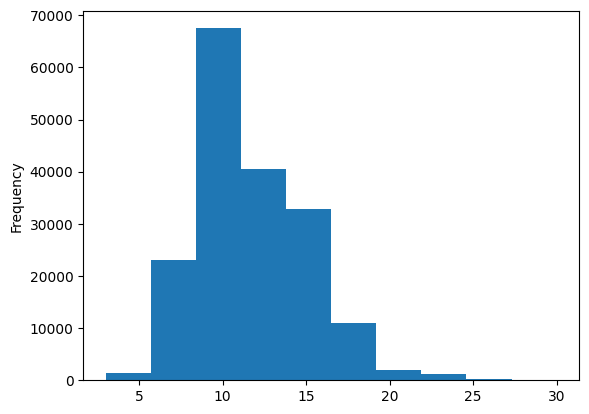

In [14]:
# let's check the length of different lines
train_df.total_lines.plot.hist();

### Get lists of sentences

In [15]:
# convert abstract text lines into lists
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()
assert len(train_sentences) == len(train_df)
assert len(val_sentences) == len(val_df)
assert len(test_sentences) == len(test_df)

In [16]:
train_sentences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

## Making Numeric Labels

In [17]:
# one hot encode labels
import sklearn
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

In [18]:
test_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [19]:
# label encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

In [20]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [21]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Modelling Experiments

## Model 0: Baseline (TF-IDF Multinomial Naive Bayes Classifier)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
# create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])
# fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
                y=val_labels_encoded)

0.7218323844829869

In [24]:
# make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import calculate_results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds,)
baseline_results

--2023-11-30 11:13:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-30 11:13:16 (81.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


In [26]:
# how long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

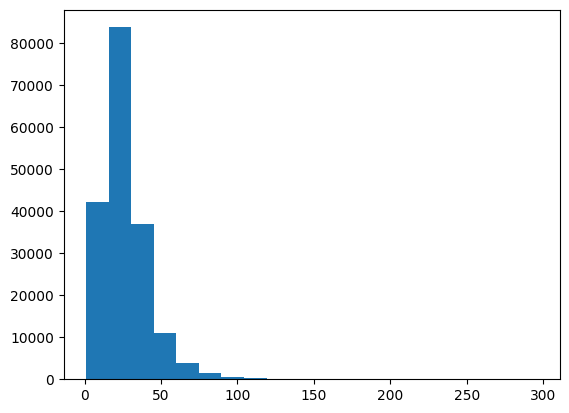

In [27]:
# what's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [28]:
# use numpy percentile to get the word length that covers 95% of the data
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

### 1. Create a text vectorization layer
maps: words -> numbers

In [29]:
# taken from the paper, vocab size
max_tokens = 68000
# create text vectorizer
from tensorflow.keras.layers import TextVectorization
textvectorizer = TextVectorization(
    max_tokens = max_tokens,
    output_sequence_length =output_seq_len

)

# adapt text vectorizer to training sentences
textvectorizer.adapt(train_sentences)

In [30]:
# test out textvectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {textvectorizer(target_sentence)}")

Text:
Exclusion criteria are known monochorionic twins or clinical evidence of twin-twin transfusion syndrome , triplet 
or higher order multiple pregnancy , and known major congenital malformation .

Length of text: 27

Vectorized text: [ 2848   391    58   682 25685 12895    16    47   299     4 33473  1082
   392 33528    16    82   923   466   540     3   682   347  4250 12007
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]

In [31]:
# how many words in our training vocabulary
rct_20k_text_vocab = textvectorizer.get_vocabulary()

print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common: {rct_20k_text_vocab[:5]}")
print(f"Least common: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841

Most common: ['', '[UNK]', 'the', 'and', 'of']

Least common: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']

In [32]:
# get the config of our text vectorizer
textvectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### 2. Create an embedding layer

In [33]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               # note different embedding sizes result in different number of parameters to train
                               output_dim=128,
                               mask_zero = True,
                               name = "token_embedding"
                               )


In [34]:
# testing it out
print(f"Show sentence before vectorization: \n {target_sentence}\n")
vectorized_sentence = textvectorizer([target_sentence])
print(f"Sentence after vectorization: \n {vectorized_sentence}")
print("Shape:", end="")
print(vectorized_sentence.shape)
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding: \n{embedded_sentence}")
print("Shape:", end="")
print(embedded_sentence.shape)

Show sentence before vectorization: 
 Exclusion criteria are known monochorionic twins or clinical evidence of twin-twin transfusion syndrome , triplet 
or higher order multiple pregnancy , and known major congenital malformation .

Sentence after vectorization: 
 [[ 2848   391    58   682 25685 12895    16    47   299     4 33473  1082
    392 33528    16    82   923   466   540     3   682   347  4250 12007
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Shape:

(1, 55)

Sentence after embedding: 
[[[ 0.00073566 -0.03506926  0.02853885 ... -0.02250504 -0.00048736
    0.02273922]
  [ 0.03586557 -0.04091865 -0.00464274 ... -0.02806585  0.02211927
    0.03262491]
  [-0.00092893  0.01801242 -0.04603535 ... -0.00662405  0.01547067
   -0.01359942]
  ...
  [-0.02832781  0.03384126  0.00015561 ... -0.03674925  0.04836161
    0.01311595]
  [-0.02832781  0.03384126  0.00015561 ... -0.03674925  0.04836161
    0.01311595]
  [-0.02832781  0.03384126  0.00015561 ... -0.03674925  0.04836161
    0.01311595]]]

Shape:

(1, 55, 128)

## Creating Datasets (making sure our data loads as fast as possible)

[Build Tensorflow input pipelines](https://www.tensorflow.org/guide/data)

[Better Performance with `tf.data` API](https://www.tensorflow.org/guide/data_performance)

In [35]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_labels_one_hot)
)
valid_dataset = tf.data.Dataset.from_tensor_slices(
    (val_sentences, val_labels_one_hot)
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_sentences, test_labels_one_hot)
)
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [36]:
# turn the TEnsorSliceDataset to Prefetched Datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [37]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [38]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape = (1), dtype=tf.string)
textvectors = textvectorizer(inputs) # vectorize or map text inputs to integers
token_embeddings = token_embed(textvectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the outpuyt of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

# compile
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics='accuracy')
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [39]:
len(train_dataset)

5627

In [40]:
# fit the model
history_1 = model_1.fit(train_dataset,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        epochs=3,
                        validation_data=valid_dataset,
                        validation_steps = int(0.1*len(valid_dataset))
                        )

Epoch 1/3
562/562 [==============================] - 33s 33ms/step - loss: 0.9131 - accuracy: 0.6386 - val_loss: 0.6787 - val_accuracy: 0.7430
Epoch 2/3
562/562 [==============================] - 10s 17ms/step - loss: 0.6556 - accuracy: 0.7571 - val_loss: 0.6315 - val_accuracy: 0.7703
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.6174 - accuracy: 0.7746 - val_loss: 0.5950 - val_accuracy: 0.7842


### Evaluating model_1

In [41]:
# evaluate on validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 7s 7ms/step - loss: 0.5969 - accuracy: 0.7859


[0.5968881845474243, 0.7858797907829285]

In [42]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs.shape
model_1_pred = tf.argmax( model_1_pred_probs, axis=1 )
display(model_1_pred.shape, model_1_pred_probs.shape)
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_pred)
model_1_results

945/945 [==============================] - 4s 4ms/step


TensorShape([30212])

(30212, 5)

{'accuracy': 78.58797828677346,
 'precision': 0.7823854428956138,
 'recall': 0.7858797828677346,
 'f1': 0.7833125246920171}

In [43]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## 2. Model 2: Feature extraction with pretrained token embedding

In [44]:
import tensorflow_hub as hub
tfhub_embeddinglayer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                      trainable=False,
                                      name='universal-sentence-encoder')
from tensorflow.keras.utils import plot_model

In [45]:
random_train_sentence = random.choice(train_sentences)
print("Sentence before embedding: \n", random_train_sentence)
print("Sentence after embedding: \n")
use_embedded_sentence = tfhub_embeddinglayer([random_train_sentence])
print(use_embedded_sentence)
print(f"Length and shape: ", len(use_embedded_sentence), use_embedded_sentence.shape)

Sentence before embedding: 
 The mean increase in femoral tunnel diameters observed in group A was significantly higher than that observed in 
group B ( p < @ ) The mean tibial tunnel diameter increased significantly from @ mm to @ mm in group A and from @ 
mm to @ mm in group B.

Sentence after embedding:

tf.Tensor(
[[-3.43068987e-02  9.75569990e-03  4.22947248e-03 -5.66822402e-02
  -3.34246755e-02 -7.12973699e-02 -6.32812409e-03 -5.82523495e-02
  -4.56691580e-03  3.90888527e-02  6.53317943e-02 -4.67662588e-02
   6.13503754e-02 -3.61689221e-04 -3.74460444e-02  5.52470759e-02
  -5.39667904e-02  4.65181284e-02 -4.85162809e-03 -8.10332317e-03
  -6.31814897e-02 -2.53557619e-02 -2.47143153e-02 -1.31370814e-03
   3.20801660e-02  4.39183563e-02  6.01297282e-02 -3.54147963e-02
  -5.21693826e-02  7.75459572e-04 -2.75170449e-02  7.08102360e-02
  -1.14040496e-03 -3.38486396e-02 -2.33203862e-02  2.09987182e-02
  -2.29432788e-02  7.09592402e-02 -1.54719735e-02 -6.99517280e-02
   9.51003109e-04  4.16582860e-02 -2.33335998e-02 -2.55852118e-02
  -7.87162688e-03  1.91094745e-02 -1.62176993e-02 -7.41479825e-03
  -4.19580713e-02 -3.02335806e-02  4.82805036e-02 -4.80971225e-02
  -5.48857898e-02 -4.22490090e-02 -1.41479047e-02  4.28413488e-02
  -7.12095499e-02  8.77672806e-03  6.49955124e-02 -5.45006245e-02
  -1.49476929e-02 -6.77200556e-02  4.19835597e-02 -3.70992757e-02
   1.29657341e-02 -3.01441718e-02  4.55763042e-02  3.96932252e-02
  -1.87069084e-02 -2.12981291e-02  3.67501378e-02  2.97852829e-02
   3.41144130e-02  6.02218360e-02 -3.16778757e-03 -3.45163532e-02
   3.68243493e-02  3.62076536e-02  3.52091901e-02  4.86019216e-02
   4.32720631e-02  7.12706447e-02 -5.06544821e-02 -6.74818382e-02
  -6.55598417e-02  6.84303120e-02 -2.33631134e-02  5.33301048e-02
   2.26883292e-02 -4.88920175e-02 -1.42630488e-02  1.98867004e-02
   1.42709557e-02 -3.78762074e-02  1.94804110e-02  1.51063246e-03
   2.46752370e-02 -4.26073372e-02 -6.86474442e-02 -2.68577458e-03
  -7.07092062e-02 -4.73072473e-03 -8.55508260e-03 -3.68433259e-02
  -5.42720838e-04  2.38722861e-02  3.78609933e-02  4.79217656e-02
   7.14047104e-02 -4.08308916e-02  2.97269057e-02  2.15108506e-02
   4.85661216e-02 -6.64413944e-02  3.53027135e-02 -4.84907590e-02
   7.84070697e-03  6.86962754e-02  4.33167405e-02 -3.48790884e-02
  -6.52310252e-02 -1.42661072e-02 -3.78914177e-02  4.23870832e-02
  -5.05007058e-02 -1.74021162e-02  6.06792942e-02  9.39323008e-03
  -5.52056804e-02 -1.49727454e-02 -1.43858250e-02 -5.15416563e-02
   6.86096475e-02 -1.73524637e-02 -3.70985605e-02 -5.82007766e-02
  -3.76753649e-03  6.81011453e-02  6.89414982e-03 -6.98650628e-02
   4.08123322e-02  5.17398827e-02 -2.77868435e-02 -5.93339205e-02
   4.32939194e-02  6.56243414e-02  6.69658855e-02 -5.46622574e-02
  -2.81545557e-02 -5.50884195e-02  6.15813360e-02  5.27165569e-02
  -1.04951086e-02 -7.08544999e-02  3.83236967e-02  5.74731119e-02
   2.18929350e-02  2.36229245e-02 -5.96579723e-02 -2.00422946e-03
  -2.27779970e-02  4.96249162e-02 -6.20986521e-02  6.92426637e-02
  -2.56462246e-02 -2.85354592e-02  6.77581131e-02 -3.88427302e-02
  -5.58075728e-03  2.92238351e-02 -6.19256720e-02 -4.41194586e-02
  -1.66888144e-02  6.30620345e-02 -3.85045148e-02  6.76872432e-02
   7.43990857e-03  7.03862607e-02  6.92496374e-02  7.03389272e-02
   3.42443446e-03  5.52769974e-02 -2.40829177e-02  7.18641952e-02
  -6.31088810e-03  3.40552367e-02 -2.16278210e-02 -1.19150179e-02
  -4.39411402e-02 -1.57161476e-03  5.75873516e-02 -1.87866595e-02
  -1.48784192e-02  6.62348121e-02  4.58307676e-02 -2.12235041e-02
  -7.05351979e-02  4.32820991e-03 -6.42902255e-02 -7.90977012e-03
  -7.15717673e-02  4.65597063e-02  6.49392828e-02  3.00988257e-02
  -6.20357618e-02  3.23690735e-02 -4.43614461e-02  5.69517612e-02
  -6.79004565e-02  1.59052089e-02  3.34270447e-02  2.68764421e-03
  -6.19298965e-02  3.85398865e-02 -6.46697357e-02  6.68208003e-02
   6.69735968e-02 -6.93361787e-03  5.84459119e-02  6.96396604e-02
   5.77830672e-02 -2.93700136e-02  6.59017488e-02 -3.36669870e-02
   6.48474768e-02  1.99448992e-03 -6.21202514e-02 -6.99155852e-02
  -6.92386925e-02  6.39777184e-02 -2.16696411e-03  2.77127828e-02
   2.97560859e-02 -4.82208617e-02  6.36739358e-02  6.12639962e-03
   6.33146018e-02 -1.21353865e-02  3.70127559e-02  5.36501780e-02
   3.51359919e-02  5.42713180

Length and shape:  1 (1, 512)

In [46]:
inputs = layers.Input(shape=[], dtype=tf.string)
use_embedded = tfhub_embeddinglayer(inputs)
x = layers.Dense(128, activation='softmax')(use_embedded)
outputs = layers.Dense(5, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2")
display (model_2.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal-sentence-encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


None

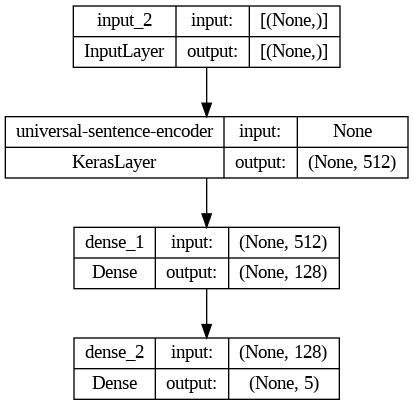

In [47]:
plot_model(model_2, show_shapes=True)

In [48]:
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics='accuracy')

In [49]:
history_2 = model_2.fit(train_dataset,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        epochs=3,
                        validation_data=valid_dataset,
                        validation_steps = int(0.1*len(valid_dataset))
                        )

Epoch 1/3
562/562 [==============================] - 21s 30ms/step - loss: 1.4460 - accuracy: 0.4857 - val_loss: 1.2652 - val_accuracy: 0.5136
Epoch 2/3
562/562 [==============================] - 13s 23ms/step - loss: 1.0930 - accuracy: 0.5907 - val_loss: 0.9868 - val_accuracy: 0.6180
Epoch 3/3
562/562 [==============================] - 13s 23ms/step - loss: 0.9497 - accuracy: 0.6264 - val_loss: 0.9052 - val_accuracy: 0.6360


In [50]:
# evaluating on the entire validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.9071 - accuracy: 0.6372


[0.9071372151374817, 0.6371640563011169]

### Evaluating model_2

In [51]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs.shape
model_2_pred = tf.argmax( model_2_pred_probs, axis=1 )
display(model_2_pred.shape, model_2_pred_probs.shape)
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_pred)
model_2_results

945/945 [==============================] - 15s 15ms/step


TensorShape([30212])

(30212, 5)

{'accuracy': 63.716404077849866,
 'precision': 0.6700773227685232,
 'recall': 0.6371640407784986,
 'f1': 0.596405073138904}

In [52]:
model_1_results, baseline_results

({'accuracy': 78.58797828677346,
  'precision': 0.7823854428956138,
  'recall': 0.7858797828677346,
  'f1': 0.7833125246920171},
 {'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294})

## Model 3: A Conv1D with Character Embeddings

The paper stated that they used a combination of token and character embeddings. Previously, we made token-level embeddings and we want to do char-level embeddings.

--2023-11-30 11:32:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-token-vs-character-embeddings.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210220 (205K) [image/png]
Saving to: ‘09-token-vs-character-embeddings.png.1’

09-token-vs-charact 100%[===================>] 205.29K  --.-KB/s    in 0.01s   

2023-11-30 11:32:07 (16.7 MB/s) - ‘09-token-vs-character-embeddings.png.1’ saved [210220/210220]



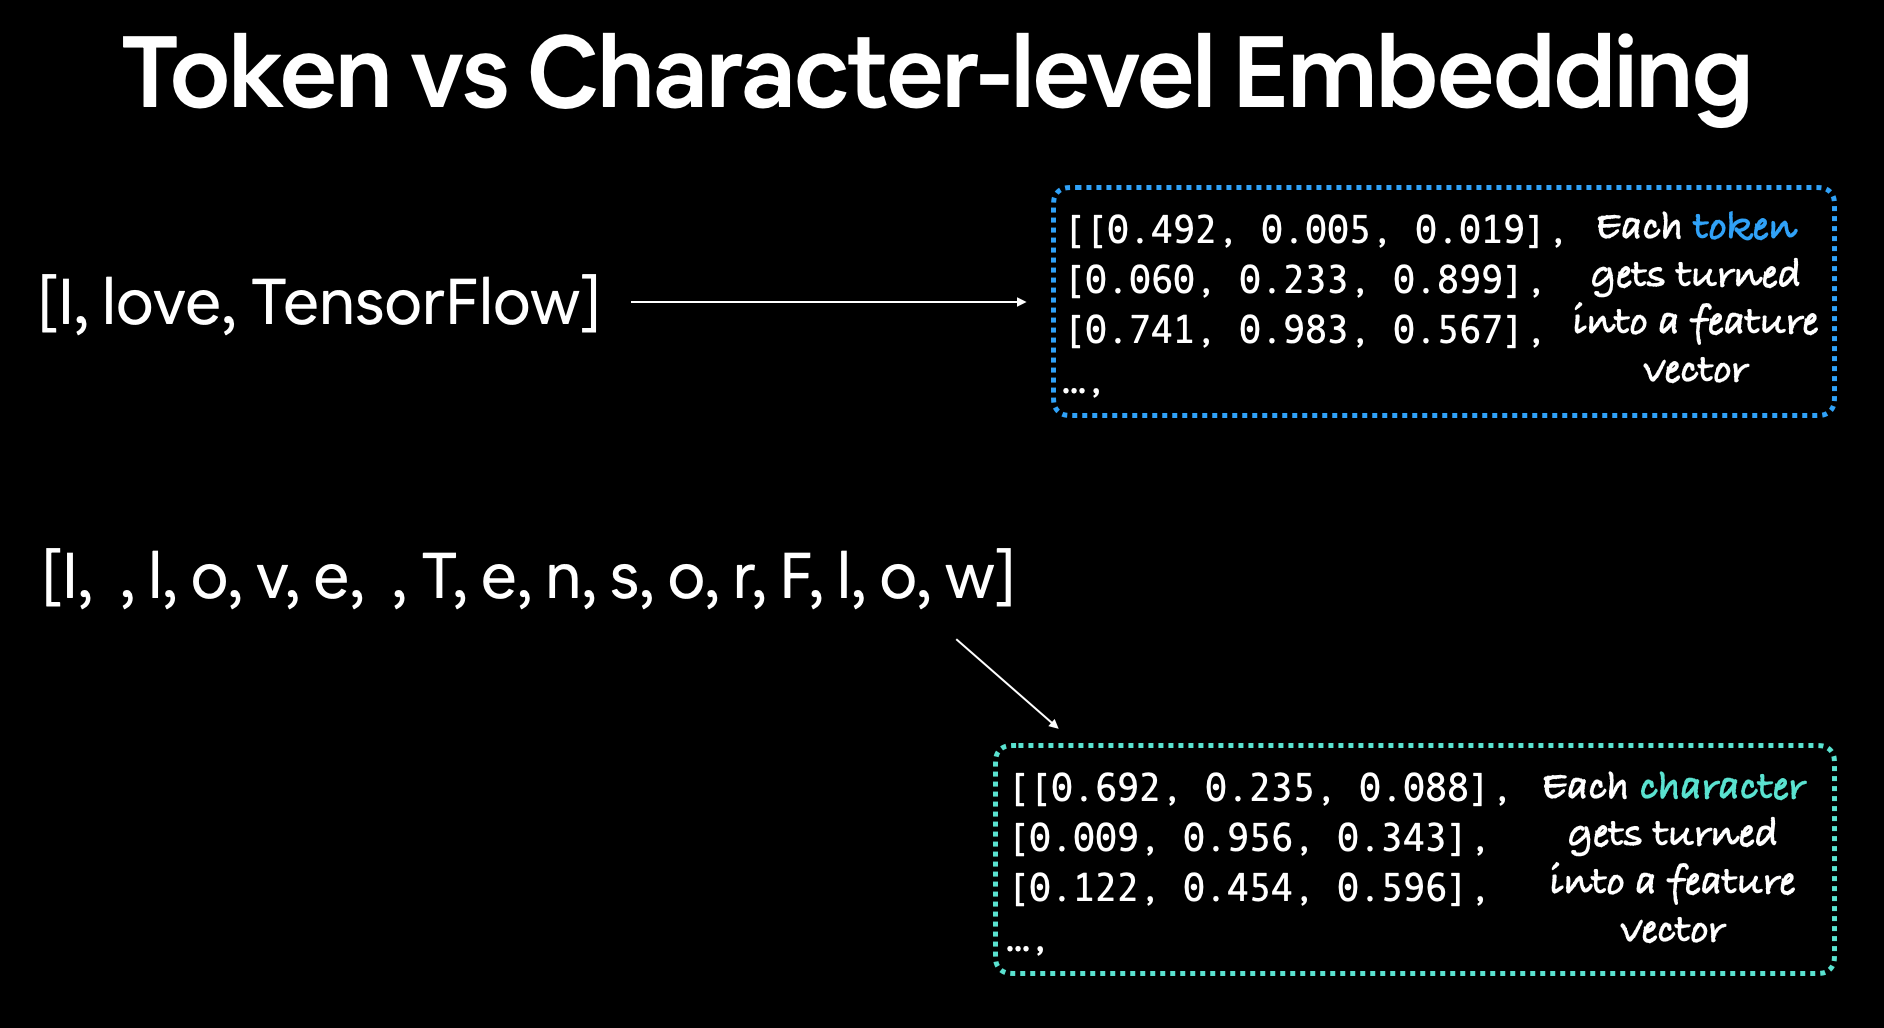

In [74]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-token-vs-character-embeddings.png

from IPython.display import Image
Image("09-token-vs-character-embeddings.png")

### 1. Create a character-level tokenizer

In [75]:
# make function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

split_chars(random_train_sentence)

'T h e   m e a n   i n c r e a s e   i n   f e m o r a l   t u n n e l   d i a m e t e r s   o b s e r v e d   i n   g r o u p   A   w a s   s i g n i f i c a n t l y   h i g h e r   t h a n   t h a t   o b s e r v e d   i n   g r o u p   B   (   p   <   @   )   T h e   m e a n   t i b i a l   t u n n e l   d i a m e t e r   i n c r e a s e d   s i g n i f i c a n t l y   f r o m   @   m m   t o   @   m m   i n   g r o u p   A   a n d   f r o m   @   m m   t o   @   m m   i n   g r o u p   B .'

In [76]:
# split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .',
 'A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [77]:
# average character length
chars_lens = [len(sentence) for sentence in train_sentences]
mean_chars_lens = np.mean(chars_lens)
mean_chars_lens

149.3662574983337

(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3950e+02, 2.7800e+02, 4.1650e+02, 5.5500e+02,
        6.9350e+02, 8.3200e+02, 9.7050e+02, 1.1090e+03, 1.2475e+03,
        1.3860e+03]),
 <BarContainer object of 10 artists>)

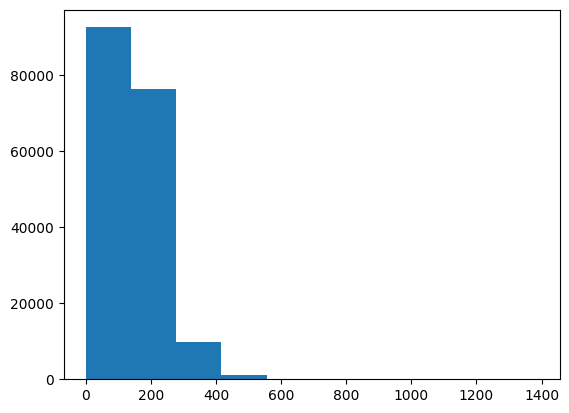

In [78]:
# check distribution
import matplotlib.pyplot as plt
plt.hist(chars_lens, bins=10)

In [79]:
# find the character length that covers 95% of sequences
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

290

In [80]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [81]:
# create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV (out of vocab) token
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize='lower')
# adapt char_vectorizer to training character
char_vectorizer.adapt(train_chars)
# check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 57

5 most common characters: ['', '[UNK]', 'e', 't', 'i']

5 least common characters: ['|', '"', ']', '\\', '[']

In [82]:
char_vectorizer

In [83]:
# test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars)}")
vectorized_chars = char_vectorizer(random_train_chars)
print(f"Vectorized Chars:\n{vectorized_chars}")
print(f"Length and shape of vectorized chars: \t{len(vectorized_chars)} \t{vectorized_chars.shape}")

Charified text:
 P a r t i c i p a n t s   (   N   =   @   )   w e r e   r a n d o m i z e d   t o   e i t h e r   a n   i n t e r 
v e n t i o n   (   N   =   @   )   o r   c o n t r o l   (   N   =   @   )   g r o u p   .

Length of random_train_chars: 205

Vectorized Chars:
[14  5  8  3  4 11  4 14  5  6  3  9 28  6 33 19 27 21  2  8  2  8  5  6
 10  7 15  4 32  2 10  3  7  2  4  3 13  2  8  5  6  4  6  3  2  8 22  2
  6  3  4  7  6 28  6 33 19 27  7  8 11  7  6  3  8  7 12 28  6 33 19 27
 18  8  7 16 14 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]

Length and shape of vectorized chars:   290     (290,)

### Create a character-level embedding

In [84]:
# Create char embedding layer
char_embed = layers.Embedding(
    input_dim = len(char_vocab),
    output_dim = 25, # from the paper
    mask_zero=True,
    name='char_embed'
)

In [85]:
# test out the char_embedding
print(f"Charified text: {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded text (after vectorization and embedding):\n {char_embed_example}")
print(f"Shape: {char_embed_example.shape}")

Charified text: P a r t i c i p a n t s   (   N   =   @   )   w e r e   r a n d o m i z e d   t o   e i t h e r   a
n   i n t e r v e n t i o n   (   N   =   @   )   o r   c o n t r o l   (   N   =   @   )   g r o u p   .

Embedded text (after vectorization and embedding):
 [[[-0.03217956  0.04171077  0.04269601 ... -0.04211108 -0.01750393
   -0.01835797]
  [ 0.04310584 -0.0351228   0.04909455 ... -0.00430833  0.03703029
   -0.0439992 ]
  [-0.03491081 -0.01695021 -0.00721973 ...  0.0480302   0.01293402
    0.00259386]
  ...
  [-0.02222681 -0.01213878 -0.01509656 ...  0.014212   -0.0115831
   -0.01156714]
  [-0.02222681 -0.01213878 -0.01509656 ...  0.014212   -0.0115831
   -0.01156714]
  [-0.02222681 -0.01213878 -0.01509656 ...  0.014212   -0.0115831
   -0.01156714]]]

Shape: (1, 290, 25)

### Building a Conv1D model to fit on character embeddings

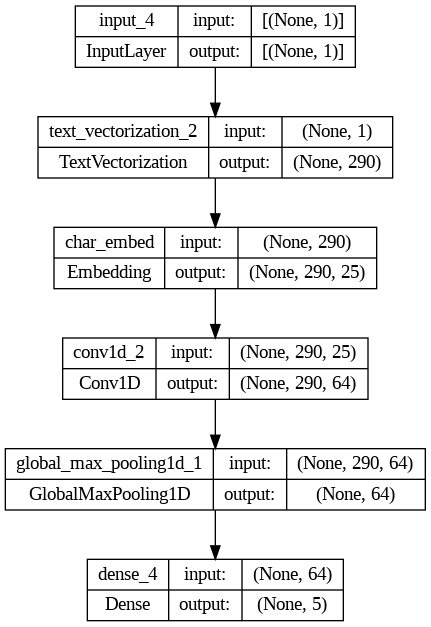

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 290)               0         
 Vectorization)                                                  
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1425      
                                                                 
 conv1d_2 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 

In [87]:
# make Conv1D on char only
inputs = layers.Input(shape=(1,), dtype='string')
char_vectors = char_vectorizer(inputs)
char_embedding = char_embed(char_vectors)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  padding='same',
                  activation='relu')(char_embedding)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs,
                         name="model_3_conv1d_char_embeddings")

# compile model
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")
display(plot_model(model_3, show_shapes=True))
model_3.summary()

In [88]:
char_train_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
char_val_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
char_test_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
char_train_dataset, len(char_train_dataset)

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 5627)

In [89]:
# first run with GlobalAveragePooling
history_3 = model_3.fit(char_train_dataset,
            epochs=5,
            steps_per_epoch=int(0.1*len(char_train_dataset)),
            validation_data = char_val_dataset,
            validation_steps = int(0.1*len(char_val_dataset)))

Epoch 1/5
562/562 [==============================] - 7s 10ms/step - loss: 1.1672 - accuracy: 0.5339 - val_loss: 0.9582 - val_accuracy: 0.6260
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 0.9060 - accuracy: 0.6439 - val_loss: 0.8581 - val_accuracy: 0.6639
Epoch 3/5
562/562 [==============================] - 4s 6ms/step - loss: 0.8353 - accuracy: 0.6760 - val_loss: 0.7972 - val_accuracy: 0.6908
Epoch 4/5
562/562 [==============================] - 4s 8ms/step - loss: 0.7877 - accuracy: 0.6942 - val_loss: 0.7690 - val_accuracy: 0.7025
Epoch 5/5
562/562 [==============================] - 4s 7ms/step - loss: 0.7727 - accuracy: 0.7031 - val_loss: 0.7396 - val_accuracy: 0.7128


In [90]:
# changed GlobalAveragePooling to GlobalMaxPooling...
history_3 = model_3.fit(char_train_dataset,
            epochs=5,
            steps_per_epoch=int(0.1*len(char_train_dataset)),
            validation_data = char_val_dataset,
            validation_steps = int(0.1*len(char_val_dataset)))

Epoch 1/5
562/562 [==============================] - 4s 7ms/step - loss: 0.7498 - accuracy: 0.7087 - val_loss: 0.7172 - val_accuracy: 0.7244
Epoch 2/5
562/562 [==============================] - 4s 8ms/step - loss: 0.7277 - accuracy: 0.7179 - val_loss: 0.7121 - val_accuracy: 0.7221
Epoch 3/5
562/562 [==============================] - 4s 7ms/step - loss: 0.7145 - accuracy: 0.7284 - val_loss: 0.6912 - val_accuracy: 0.7387
Epoch 4/5
562/562 [==============================] - 3s 6ms/step - loss: 0.6963 - accuracy: 0.7317 - val_loss: 0.6871 - val_accuracy: 0.7407
Epoch 5/5
562/562 [==============================] - 3s 6ms/step - loss: 0.6987 - accuracy: 0.7344 - val_loss: 0.6748 - val_accuracy: 0.7430


### Evaluating

In [91]:
model_3_pred_probas = model_3.predict(char_test_dataset)
model_3_preds = tf.argmax(model_3_pred_probas, axis=1)
model_3_labels = class_names[model_3_preds]

942/942 [==============================] - 4s 4ms/step


In [92]:
model_3_results = calculate_results(y_true = test_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results, baseline_results, model_1_results, model_2_results

({'accuracy': 73.13091090094575,
  'precision': 0.7353769707803076,
  'recall': 0.7313091090094574,
  'f1': 0.7275686942906294},
 {'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294},
 {'accuracy': 78.58797828677346,
  'precision': 0.7823854428956138,
  'recall': 0.7858797828677346,
  'f1': 0.7833125246920171},
 {'accuracy': 63.716404077849866,
  'precision': 0.6700773227685232,
  'recall': 0.6371640407784986,
  'f1': 0.596405073138904})

# Suggestions:
Increase the kernel size to at least average word length

## Model 4: Building a multi-input model (hybrid token and character embedding):

1. Create a token-level embedding model (similar model_1)
2. Create a character_level embedding model
3. Combine 1 & 2 using `layers.Concatenate`
4. build layers according to the paper
5. construct the model with 1 & 2 as inputs and produces sequence label probabilities as output.

In [123]:
# 1. set up token inputs
token_inputs = layers.Input(shape=[], dtype = tf.string, name='token_input')
token_embedddings = tfhub_embeddinglayer(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embedddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output, name="token_submodel")

# 2. set up char tokens
char_inputs = layers.Input(shape=(1,), dtype = tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)

char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm,
                            name="char_submodel")

# 3. combine with concatenate
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                              char_model.output])

# 4. build a series of output layers on top of 3, adding Dropout
combined_dropout = layers.Dropout(rate=0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(rate=0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name='model_4_token_and_char_embeddings')
model_4.compile(loss='categorical_crossentropy',
                optimizer="adam",
                metrics='accuracy')

In [106]:
from keras.utils import plot_model

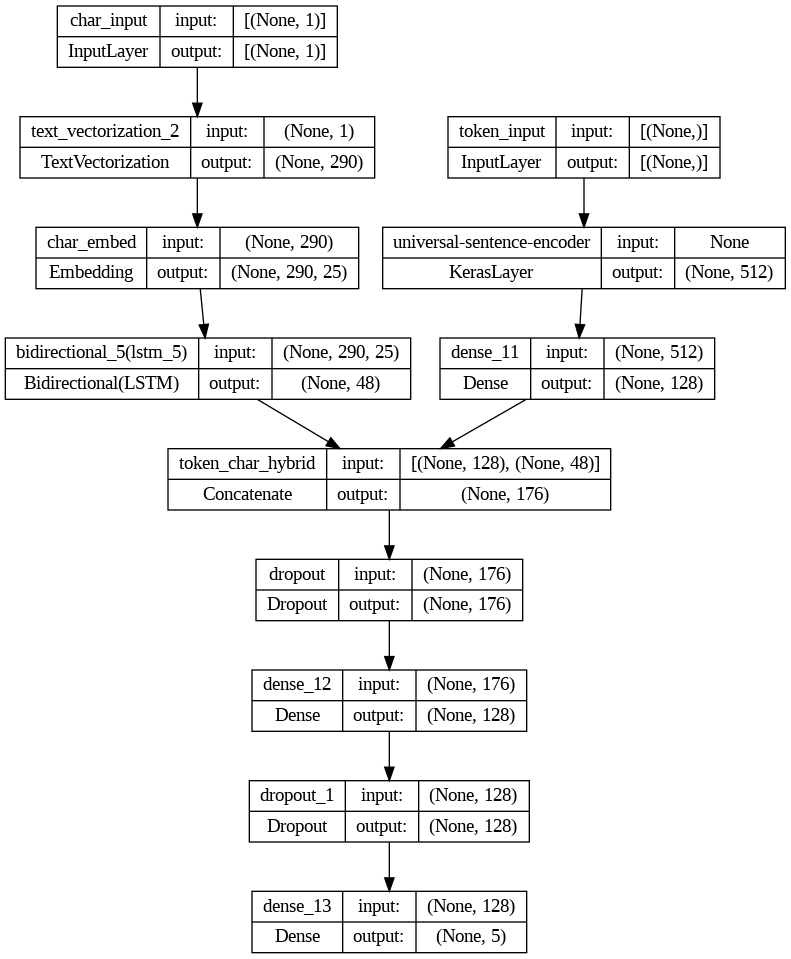

In [111]:
plot_model(model_4,
           show_shapes=True,
           expand_nested = True,
    # show_layer_activations=True,
        #    show_trainable=True,
           to_file="model_4_token_and_char_embeddings.png")

### Preparing the dataset

In [120]:
train_char_token_dataset = tf.data.Dataset.from_tensor_slices(
    ((train_sentences, train_chars),
    train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_dataset = tf.data.Dataset.from_tensor_slices(
    ((test_sentences, test_chars),
    test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset = tf.data.Dataset.from_tensor_slices(
    ((val_sentences, val_chars),
    val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [121]:
train_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
history_3 = model_3.fit(char_train_dataset,
            epochs=5,
            steps_per_epoch=int(0.1*len(char_train_dataset)),
            validation_data = char_val_dataset,
            validation_steps = int(0.1*len(char_val_dataset)))

In [126]:
history_4 = model_4.fit(
    train_char_token_dataset,
    epochs=5,
    steps_per_epoch = int(0.1*len(train_char_token_dataset)),
    validation_data = val_char_token_dataset,
    validation_steps = int(0.1*len(val_char_token_dataset))
    )

Epoch 1/5
562/562 [==============================] - 29s 51ms/step - loss: 0.6654 - accuracy: 0.7506 - val_loss: 0.5853 - val_accuracy: 0.7796
Epoch 2/5
562/562 [==============================] - 25s 44ms/step - loss: 0.6619 - accuracy: 0.7529 - val_loss: 0.5870 - val_accuracy: 0.7769
Epoch 3/5
562/562 [==============================] - 24s 42ms/step - loss: 0.6531 - accuracy: 0.7541 - val_loss: 0.5829 - val_accuracy: 0.7849
Epoch 4/5
562/562 [==============================] - 33s 58ms/step - loss: 0.6545 - accuracy: 0.7580 - val_loss: 0.5868 - val_accuracy: 0.7773
Epoch 5/5
562/562 [==============================] - 33s 58ms/step - loss: 0.6921 - accuracy: 0.7428 - val_loss: 0.6209 - val_accuracy: 0.7653


### Evaluating the model's performance

In [130]:
display(model_4.evaluate(val_char_token_dataset))

model_4_pred_probs = model_4.predict(test_char_token_dataset)
model_4_preds = model_4_pred_probs.argmax(axis=1)

model_4_results = calculate_results (model_4_preds, test_labels_encoded)

model_4_results, model_3_results, model_2_results, model_1_results, baseline_results

945/945 [==============================] - 23s 24ms/step - loss: 0.6219 - accuracy: 0.7639


[0.6219366192817688, 0.763934850692749]

942/942 [==============================] - 19s 20ms/step


({'accuracy': 75.95155135224822,
  'precision': 0.7813138870547109,
  'recall': 0.7595155135224821,
  'f1': 0.7647858891791615},
 {'accuracy': 73.13091090094575,
  'precision': 0.7353769707803076,
  'recall': 0.7313091090094574,
  'f1': 0.7275686942906294},
 {'accuracy': 63.716404077849866,
  'precision': 0.6700773227685232,
  'recall': 0.6371640407784986,
  'f1': 0.596405073138904},
 {'accuracy': 78.58797828677346,
  'precision': 0.7823854428956138,
  'recall': 0.7858797828677346,
  'f1': 0.7833125246920171},
 {'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294})

## Model 5: Transfer learning with token-embeddings + char_embeddings + sequence order

In [131]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11
...,...,...,...,...
180035,RESULTS,For the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"For PAV , a significantly greater percentage o...",8,11
180037,RESULTS,Both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"Compared with standard statin monotherapy , th...",10,11


### Create positional embeddings

**🔑 Note** : Any engineered feature used to train a model need to be available at test time.

In [132]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

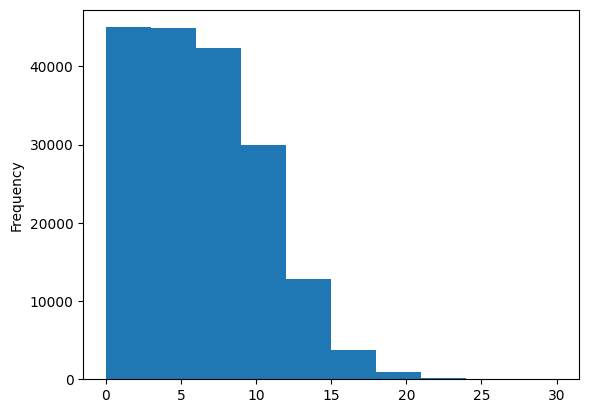

In [133]:
train_df.line_number.plot.hist()

In [149]:
np.percentile(train_df.line_number, 95), np.percentile(train_df.line_number, 5)

(13.0, 0.0)

In [138]:
train_line_numbers_one_hot = tf.one_hot(train_df.line_number.to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df.line_number.to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df.line_number.to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

<Axes: ylabel='Frequency'>

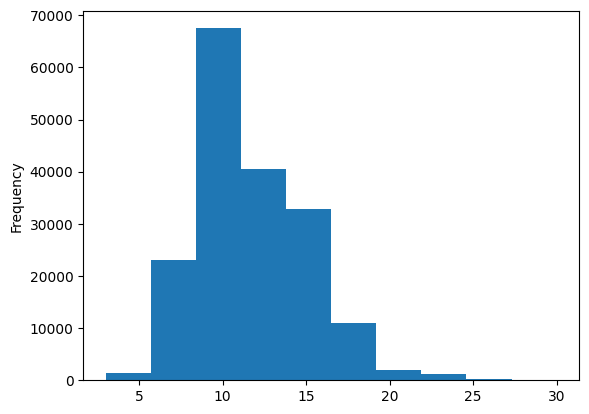

In [141]:
train_df.total_lines.plot.hist()

In [144]:
np.percentile(train_df.total_lines, 95)

18.0

In [145]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

In [186]:
train_total_lines_one_hot = tf.one_hot(train_df.total_lines.to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df.total_lines.to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df.total_lines.to_numpy(), depth=20)

In [148]:
train_total_lines_one_hot.shape

TensorShape([180040, 20])

### Building a tribid model
1. create a token-levle model
2. create character-level model
3. create a model for the 'line_number' features
4. create a model for the 'total_lines' features
5. Combine the outputs for 1 & 2 using tf.keras.layers.Concatenate
6. combine the outputs of 3, 4 & 5 using tf.keras.layers.Concatenate
7. create an output layer to accept the tribid embedding and output label probabilities
8. combine the inputs of 1-4 and the outputs of 7 into a tf.keras.Model

In [192]:
# 1. token inputs
token_inputs = layers.Input(shape = [], dtype =tf.string, name="token_inputs")
x = tfhub_embeddinglayer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(x)
token_model = tf.keras.Model(token_inputs, token_outputs, name="token_model")

# 2. char inputs
char_inputs = layers.Input(shape = (1,), dtype=tf.string, name='char_inputs')
x = char_vectorizer(char_inputs)
x = char_embed(x)
char_outputs = layers.Bidirectional(layers.LSTM(24))(x)
char_model = tf.keras.Model(char_inputs, char_outputs, name="char_model")

# 3. line number features
line_number_inputs = layers.Input(shape = (15,), dtype=tf.float32, name='line_number_input')
# x = layers.Dense(32, activation='relu')(line_number_inputs)
output =layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, output, name='line_number_model')

# 4. total lines features

## note get dtype and shape from train_total_lines_one_hot.shape and train_total_lines_one_hot.dtype
total_lines_inputs = layers.Input(shape= (20,), dtype=tf.float32, name='total_lines_input')
# x = layers.Dense(32, activation='relu')(total_lines_inputs)
output = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, output, name='total_lines_model')

# 5. combine 1 & 2
char_text_concat_layer = layers.Concatenate(name="char_text_concat")([token_model.output,
                                                                  char_model.output])

char_text_concat_layer = layers.Dense(256, activation="relu")(char_text_concat_layer)
char_text_concat_layer = layers.Dropout(rate=0.5)(char_text_concat_layer)



# 6. combine 3, 4, 5
char_text_lines_concat_layer = layers.Concatenate()(
    [char_text_concat_layer, line_number_model.output, total_lines_model.output])



# 7. create an output layer to accept the tribid embedding and output label probabilities
x = layers.Dense(128, activation='relu')(char_text_lines_concat_layer)
output_layer = layers.Dense(5, activation='sigmoid')(x)


model_5 = tf.keras.Model(inputs = [token_model.input,
                                   char_model.input,
                                   line_number_model.input,
                                   total_lines_model.input],
                         outputs = output_layer,
                         name="model_5")

model_5.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 text_vectorization_2 (Text  (None, 290)                  0         ['char_inputs[0][0]']         
 Vectorization)                                                                                   
                                                                                                  
 universal-sentence-encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

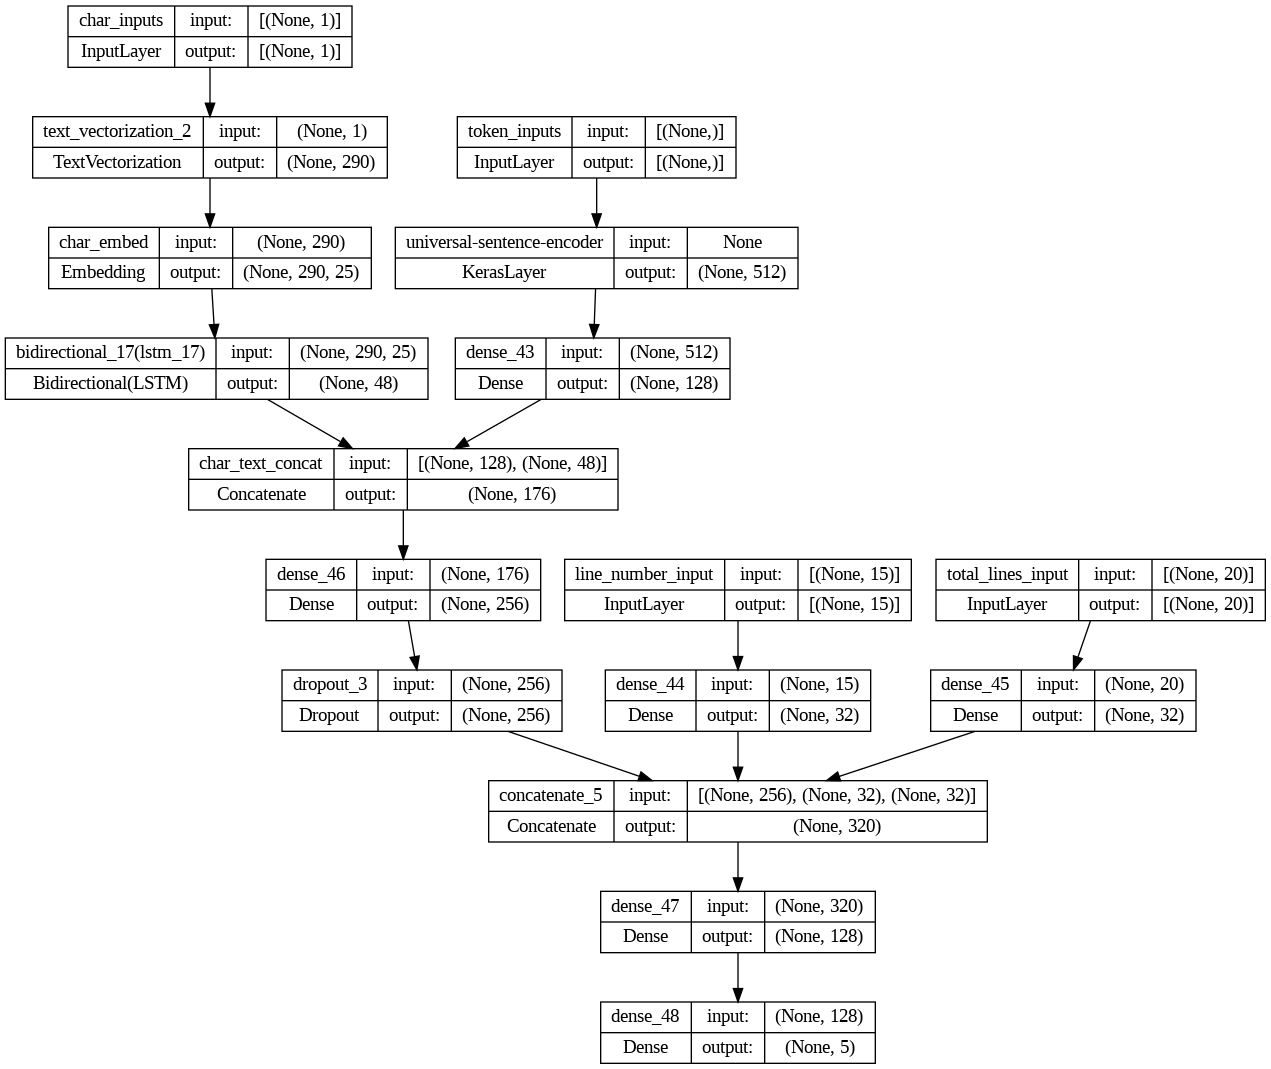

In [193]:
plot_model(model_5, show_shapes=True)

In [194]:
train_total_lines_one_hot.shape, train_total_lines_one_hot.dtype

(TensorShape([180040, 20]), tf.float32)

#### Label Smoothing

This time, we're going to introduce a new parameter to our loss function called `label_smoothing`. Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

For example, instead of having an output prediction of:

`[0.0, 0.0, 1.0, 0.0, 0.0]` for a sample (the model is very confident the right label is index 2).
It's predictions will get smoothed to be something like:

`[0.01, 0.01, 0.096, 0.01, 0.01]` giving a small activation to each of the other labels, in turn, hopefully improving generalization.

📖: https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [200]:
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer='adam',
                metrics='accuracy')

### creating the datasets

In [203]:
train_tribid_dataset = tf.data.Dataset.from_tensor_slices(
    (
        (train_sentences,
         train_chars,
         train_line_numbers_one_hot,
         train_total_lines_one_hot),
        train_labels_one_hot
     )
    ).batch(32).prefetch(tf.data.AUTOTUNE)

val_tribid_dataset = tf.data.Dataset.from_tensor_slices(
    (
        (val_sentences,
         val_chars,
         val_line_numbers_one_hot,
         val_total_lines_one_hot),
        val_labels_one_hot
     )
    ).batch(32).prefetch(tf.data.AUTOTUNE)

test_tribid_dataset = tf.data.Dataset.from_tensor_slices(
    (
        (test_sentences,
         test_chars,
         test_line_numbers_one_hot,
         test_total_lines_one_hot),
        test_labels_one_hot
     )
    ).batch(32).prefetch(tf.data.AUTOTUNE)

### Fitting the model

In [204]:
history_5 = model_5.fit(train_tribid_dataset,
                        epochs=5,
                        steps_per_epoch = int(0.1*len(train_tribid_dataset)),
                        validation_data = val_tribid_dataset,
                        validation_steps = int(0.1*len(val_tribid_dataset)),
)

Epoch 1/5
562/562 [==============================] - 31s 44ms/step - loss: 0.8586 - accuracy: 0.8733 - val_loss: 0.8595 - val_accuracy: 0.8713
Epoch 2/5
562/562 [==============================] - 24s 43ms/step - loss: 0.8446 - accuracy: 0.8832 - val_loss: 0.8567 - val_accuracy: 0.8740
Epoch 3/5
562/562 [==============================] - 23s 42ms/step - loss: 0.8436 - accuracy: 0.8807 - val_loss: 0.8615 - val_accuracy: 0.8717
Epoch 4/5
562/562 [==============================] - 23s 40ms/step - loss: 0.8444 - accuracy: 0.8850 - val_loss: 0.8584 - val_accuracy: 0.8707
Epoch 5/5
562/562 [==============================] - 23s 41ms/step - loss: 0.8406 - accuracy: 0.8876 - val_loss: 0.8526 - val_accuracy: 0.8707


### Evaluating performance

In [189]:
display(model_5.evaluate(val_tribid_dataset))

model_5_pred_probs = model_5.predict(test_tribid_dataset)
model_5_preds = model_5_pred_probs.argmax(axis=1)

model_5_results = calculate_results(model_5_preds, test_labels_encoded)
display(model_5_results)

model_4_results, model_3_results, model_2_results, model_1_results, baseline_results

945/945 [==============================] - 24s 26ms/step - loss: 0.3647 - accuracy: 0.8601


[0.36466410756111145, 0.8600887060165405]

942/942 [==============================] - 23s 20ms/step


{'accuracy': 85.63464410154306,
 'precision': 0.8718521024210375,
 'recall': 0.8563464410154306,
 'f1': 0.8597468443656232}

({'accuracy': 75.95155135224822,
  'precision': 0.7813138870547109,
  'recall': 0.7595155135224821,
  'f1': 0.7647858891791615},
 {'accuracy': 73.13091090094575,
  'precision': 0.7353769707803076,
  'recall': 0.7313091090094574,
  'f1': 0.7275686942906294},
 {'accuracy': 63.716404077849866,
  'precision': 0.6700773227685232,
  'recall': 0.6371640407784986,
  'f1': 0.596405073138904},
 {'accuracy': 78.58797828677346,
  'precision': 0.7823854428956138,
  'recall': 0.7858797828677346,
  'f1': 0.7833125246920171},
 {'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294})

In [197]:
display(model_5.evaluate(val_tribid_dataset))

model_5_pred_probs = model_5.predict(test_tribid_dataset)
model_5_preds = model_5_pred_probs.argmax(axis=1)

model_5_results = calculate_results(model_5_preds, test_labels_encoded)
display(model_5_results)

model_4_results, model_3_results, model_2_results, model_1_results, baseline_results

945/945 [==============================] - 21s 22ms/step - loss: 0.3622 - accuracy: 0.8613


[0.3622327446937561, 0.8612802624702454]

942/942 [==============================] - 35s 32ms/step


{'accuracy': 85.81715613074498,
 'precision': 0.8735922101149473,
 'recall': 0.8581715613074498,
 'f1': 0.8613366094181353}

({'accuracy': 75.95155135224822,
  'precision': 0.7813138870547109,
  'recall': 0.7595155135224821,
  'f1': 0.7647858891791615},
 {'accuracy': 73.13091090094575,
  'precision': 0.7353769707803076,
  'recall': 0.7313091090094574,
  'f1': 0.7275686942906294},
 {'accuracy': 63.716404077849866,
  'precision': 0.6700773227685232,
  'recall': 0.6371640407784986,
  'f1': 0.596405073138904},
 {'accuracy': 78.58797828677346,
  'precision': 0.7823854428956138,
  'recall': 0.7858797828677346,
  'f1': 0.7833125246920171},
 {'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294})

In [202]:
display(model_5.evaluate(val_tribid_dataset))

model_5_pred_probs = model_5.predict(test_tribid_dataset)
model_5_preds = model_5_pred_probs.argmax(axis=1)

model_5_results = calculate_results(model_5_preds, test_labels_encoded)
display(model_5_results)

model_4_results, model_3_results, model_2_results, model_1_results, baseline_results

945/945 [==============================] - 23s 24ms/step - loss: 0.8606 - accuracy: 0.8700


[0.8606410026550293, 0.8699854612350464]

942/942 [==============================] - 23s 21ms/step


{'accuracy': 86.78612908578064,
 'precision': 0.8856886060462434,
 'recall': 0.8678612908578065,
 'f1': 0.8719802522525092}

({'accuracy': 75.95155135224822,
  'precision': 0.7813138870547109,
  'recall': 0.7595155135224821,
  'f1': 0.7647858891791615},
 {'accuracy': 73.13091090094575,
  'precision': 0.7353769707803076,
  'recall': 0.7313091090094574,
  'f1': 0.7275686942906294},
 {'accuracy': 63.716404077849866,
  'precision': 0.6700773227685232,
  'recall': 0.6371640407784986,
  'f1': 0.596405073138904},
 {'accuracy': 78.58797828677346,
  'precision': 0.7823854428956138,
  'recall': 0.7858797828677346,
  'f1': 0.7833125246920171},
 {'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294})